<a href="https://colab.research.google.com/github/Generative-AI-in-Computer-Vision/generative-ai-in-computer-vision/blob/main/chapter-03/Ch03_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3: Wasserstein Generative Adversarial Network (WGAN)

## Step 1: Import Necessary Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Step 2: Enable GPU Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Step 3: Load the Dataset

In [ ]:
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Step 4: Implement the Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # Fully connected layer that reshapes the input noise vector
            nn.Linear(100, 256 * 7 * 7),
            nn.Unflatten(1, (256, 7, 7)),

            # Transposed Convolutional Layer
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.02),

            # Another Transposed Convolutional Layer
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.02),

            # Final Transposed Convolutional Layer
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

## Step 5: Implement the Critic

In [ ]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.02),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.02),

            nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0),
            nn.Flatten()
        )

    def forward(self, x):
        return self.model(x)

## Step 6: Initialize the Models and Optimizers

In [ ]:
# Initialize models
critic = Critic().to(device)
generator = Generator().to(device)

# Optimizers
critic_optimizer = optim.Adam(critic.parameters(), lr=0.0001, betas=(0.6, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.6, 0.999))

## Step 7: Train the Model

In [ ]:
# Hyperparameters
num_epochs = 250
clip_value = 1 # clipping value for the critic's weight
n_critic = 2   # number of critic updates per generator update


# Training Loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):

        # ---------------------
        #  Train Critic
        # ---------------------

        # Load real images
        real_images = images.to(device)

        critic_optimizer.zero_grad()

        # Generate a batch of images
        z = torch.randn(images.size(0), 100).to(device)  # Generate noise vector
        fake_images = generator(z)

        # Calculate critic's loss on real and fake images
        critic_real = critic(real_images).reshape(-1)
        critic_fake = critic(fake_images).reshape(-1)
        loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
        loss_critic.backward()
        critic_optimizer.step()

        # Clip weights of critic
        for p in critic.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train the generator every n_critic iterations
        if i % n_critic == 0:
            # -----------------
            #  Train Generator
            # -----------------
            generator_optimizer.zero_grad()

            # Generate a batch of images
            fake_images = generator(z)

            # Calculate loss on generator's images
            critic_fake = critic(fake_images).reshape(-1)
            loss_generator = -torch.mean(critic_fake)
            loss_generator.backward()
            generator_optimizer.step()

        # Print out the losses occasionally
        if i % 2000 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(train_loader)} \
                   Loss D: {loss_critic:.4f}, loss G: {loss_generator:.4f}")

Epoch [0/250] Batch 0/938                    Loss D: 0.2209, loss G: 0.1271
Epoch [1/250] Batch 0/938                    Loss D: -52.1971, loss G: 26.0236
Epoch [2/250] Batch 0/938                    Loss D: -125.0799, loss G: 72.8830
Epoch [3/250] Batch 0/938                    Loss D: -167.8040, loss G: 59.8373
Epoch [4/250] Batch 0/938                    Loss D: -194.6328, loss G: 163.8715
Epoch [5/250] Batch 0/938                    Loss D: -187.1171, loss G: 206.0223
Epoch [6/250] Batch 0/938                    Loss D: -164.5854, loss G: 86.5176
Epoch [7/250] Batch 0/938                    Loss D: -191.9423, loss G: 448.9267
Epoch [8/250] Batch 0/938                    Loss D: -196.5811, loss G: 121.1169
Epoch [9/250] Batch 0/938                    Loss D: -146.2784, loss G: 437.9909
Epoch [10/250] Batch 0/938                    Loss D: -120.0471, loss G: 256.8096
Epoch [11/250] Batch 0/938                    Loss D: -258.4745, loss G: 247.1240
Epoch [12/250] Batch 0/938          

## Step 8: Evaluate the Model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

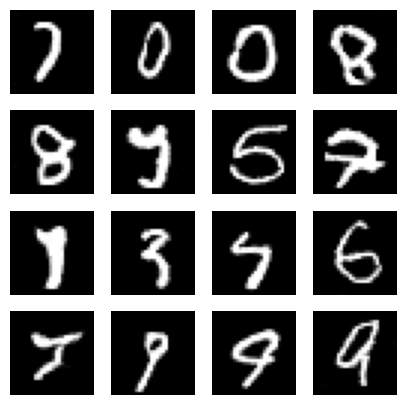

In [ ]:
# Function to generate and display images
def generate_and_show_images(model, noise, num_images=16):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        fake_images = model(noise).detach().cpu()

    # Plot and show the generated images
    plt.figure(figsize=(5, 5))
    for i in range(num_images):
        plt.subplot(4, 4, i+1)  # Assuming you want to display 64 (8x8) images
        plt.imshow(fake_images[i][0], cmap='gray')
        plt.axis('off')

    plt.show()

# Generate a fixed noise vector
fixed_noise = torch.randn(16, 100).to(device)

# Generate and display images using the trained generator
generate_and_show_images(generator, fixed_noise)

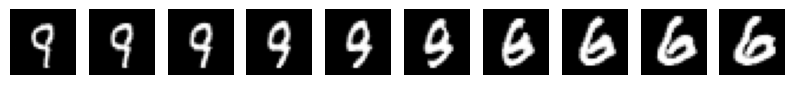

In [ ]:
def interpolate_points(p1, p2, n_steps=10):
    """ Interpolate between two points in latent space """
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = []
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.array(vectors)

def generate_images(generator, latent_vectors):
    """ Generate images from latent vectors """
    images = []
    with torch.no_grad():
        for v in latent_vectors:
            img = generator(torch.FloatTensor(v).to(device).unsqueeze(0))
            images.append(img.cpu().squeeze(0).squeeze(0).numpy())
    return images

# Generate two random latent space vectors
z1 = torch.randn(100)
z2 = torch.randn(100)

# Interpolate between z1 and z2
n_interpolations = 10  # Number of interpolation steps
interpolated_vectors = interpolate_points(z1, z2, n_steps=n_interpolations)

# Generate images from interpolated vectors
interpolated_images = generate_images(generator, interpolated_vectors)

# Display the images
plt.figure(figsize=(10, 2))
for i, img in enumerate(interpolated_images):
    plt.subplot(1, n_interpolations, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()